In [1]:
import math
import numpy as np
import pandas as pd
import sys
import itertools
from functions import *
from mining_functions import *
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

In [112]:
merge_actions = {'C':'C', 'P':'P', 'Tb':'T', 'Tc':'T', 'Ts':'T', 'To':'T'}

def make_hist_discrete(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    ymax= max(max(freq_HL),max(freq_LL))
    bins = range(0,int(ymax)+1,1)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def make_hist_continuous(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    bins = np.arange(0,1.05,0.05)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def get_frequencies(seq_of_interest,blocks1,blocks2,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(''.join(seq).count(seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
    return freq1.values(),freq2.values()

# ### Demonstration of function above
# b1 = {1:["A","Bo","C","Bo","C","A","C","A"]}
# b2 = {3:["A","Bo","C","Bo","A","Bo","A","Bo"]}
# f1,f2 = get_frequencies('BoC',b1,b2,normalize_by='Bo')
# print f1,f2

def perform_comparative_stats(seq_of_interest,freq1,freq2):
    t,p =  stats.ttest_ind(freq_HL,freq_LL,equal_var=False)
    print seq_of_interest,':'
    print "\tT-test:\t{0} \t p={1}".format(round(t,3),round(p,4))
    m,p = stats.mannwhitneyu(freq_HL,freq_LL, alternative='less')
    print '\tHL<LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    m,p = stats.mannwhitneyu(freq_HL,freq_LL, alternative='greater')
    print '\tHL>LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    
# def remodel_families_lightbulb(row):
#     if row["Family"] == "Test_complex":
#         if row['current_#lightBulb']>0:
#             if row["current_#battery"] == 1: 
#                 #we have a simple circuit ;)
#                 if row["current_#loops"] == 1:
#                     if row["current_#resistor"] == 0: #basic circuit!
#                         return 'Test_series_l'
#                     if row["current_#resistor"] == 1: #basic circuit!
#                         return 'Test_series_l_r'
#                     if row["current_#resistor"] == 2: #basic circuit!
#                         return 'Test_series_l_r_r'
#                 elif row["current_#loops"] == 2:
#                     if row["current_#resistor"] == 0: #basic circuit!
#                         return 'Test_parallel_l'
#                     if row["current_#resistor"] == 1: #basic circuit!
#                         return 'Test_parallel_l_r'
#                     if row["current_#resistor"] == 2: #basic circuit!
#                         return 'Test_parallel_l_r_r'
#     return row["Family"]
# df2 = df.copy()
# df2['Family'] = df2.apply (lambda row: remodel_families_lightbulb (row),axis=1)

# blocks_HL_lightbulb, time_coords_HL =  get_blocks_withTime_new(df2,students_HL,"Family",start=False,ignore=['I'], as_list=True)
# blocks_LL_lightbulb, time_coords_LL =  get_blocks_withTime_new(df2,students_LL,"Family",start=False,ignore=['I'], as_list=True)

# Story line
This notebook raises and explores hypotheses generated fom the analysis in the notebook  "temporal_sequence_infogain_mining.ipynb"

Here are the Hypotheses:
* CTsPTsP (HL)
    * TsP
        * Ts (**1.1**)
        * TP (**1.2**)
    * TsPTsP
        * TPTP (**2.1**)
* PCTcCTcC (LL)
    * TcC
        * Tc (**3.1**)
        * TC (**3.2**)
    * TcCTcC
        * TCTC (**4.1**)
* PCPCTcC (LL)
    * PC (**5.1**)
    * CP (**5.2**)
* PTsPC (HL)
    * PTs
    * PT (**6**)


# Frequency analysis of single blocks of actions -> Hypotheses 1.1 and 3.1
First we get the sequence of action of each students in blocks. Recall that we only look at students who had a low pre.
We also ignore the Interface actions becasue they aren't interesting.

In [40]:
students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
students_HL = H_post.intersection(students_Lpre)
students_LL = L_post.intersection(students_Lpre)
print "There are {0} low pre students, of which {1} are high learners and {2} low learners.".format(len(students_Lpre),len(students_HL),len(students_LL))

There are 74 low pre students, of which 38 are high learners and 36 low learners.


In [41]:
blocks_HL, time_coords_HL =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I'], as_list=True)
blocks_merged_HL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_HL.iteritems()}
blocks_merged_LL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_LL.iteritems()}
actions_merged = ['C','P','T']
actions_all = ['C', 'P', 'Tb', 'Tc', 'Ts']

We may need to plot sequences so let's load them up

In [42]:
CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
shortest_seq_length = 1
longest_seq_length = 10
B = 4  #number of bins
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students_Lpre,family_category,
                                                          B,'split post t2','high','low',
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


First we need to check that students tend to do the same number of blocks of actions in their sequences

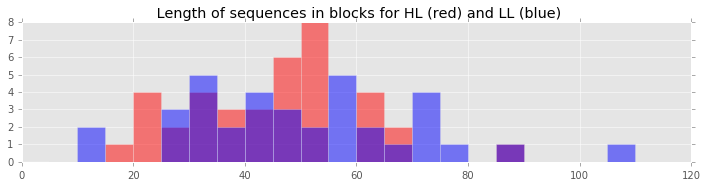

In [43]:
length_HL = [len(seq) for seq in blocks_HL.values()];length_LL = [len(seq) for seq in blocks_LL.values()]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= max(max(length_HL),max(length_LL))
bins = range(0,ymax+5,5)
plt.hist(length_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(length_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Length of sequences in blocks for HL (red) and LL (blue)")

Indeed they do not! We are going to have to normalize given the length of each student's sequence.

But first let's see how many blocks of each type of action students do.

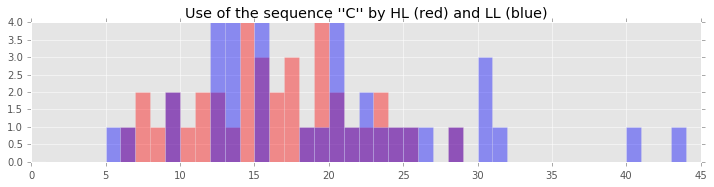

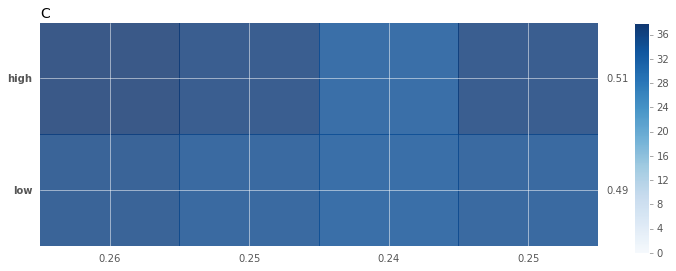

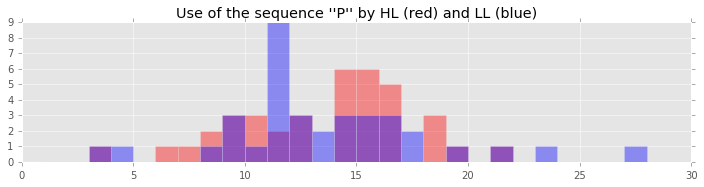

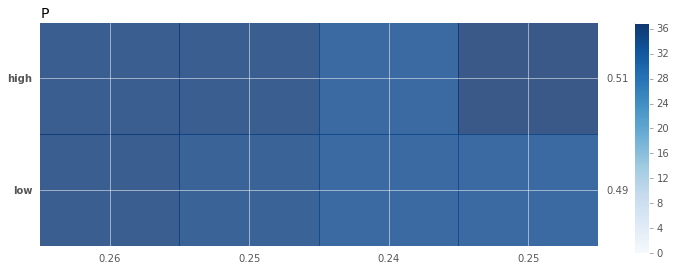

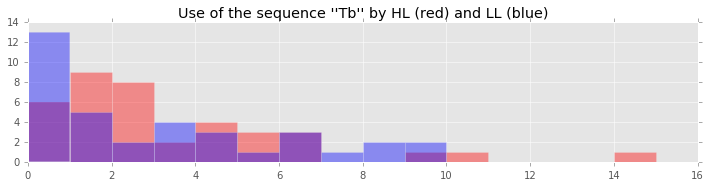

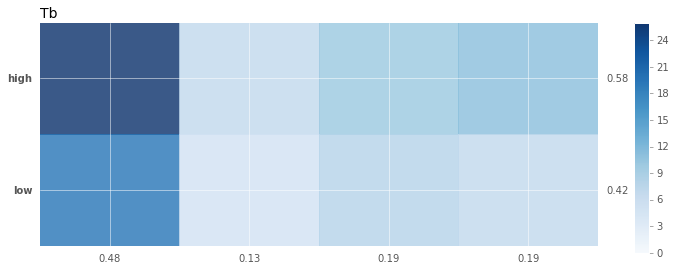

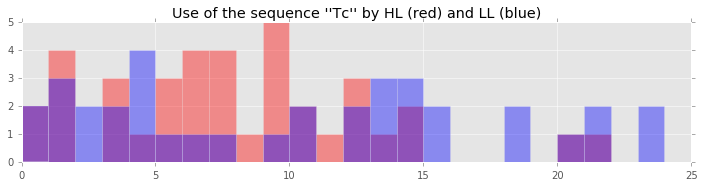

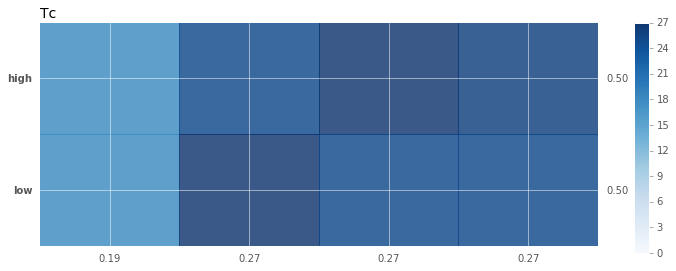

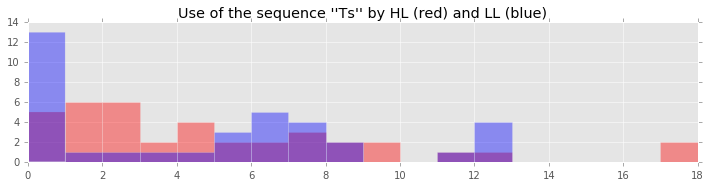

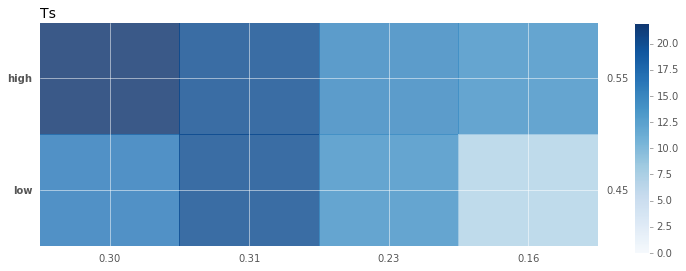

In [44]:
for action in actions_all:
    freq_HL,freq_LL = get_frequencies(action,blocks_HL,blocks_LL,normalize_by=None)
    make_hist_discrete(action,freq_HL,freq_LL)
    plot_heat_map(sequence_counts[action],action,('high','low'))

We notice that:
* Everyone constructs and pause during the entire activity
* Everyone Test simple and basic early as well as Test complex late. 
* some students never Test basic (13 LL, 6 HL) nor Test simple (13 LL and 5 HL).
* Several LL do many many Test complex actions, and do them earlier on in the activity
* Several LL have more Construct blocks.

Note that we don't look at Test other because only 9 students use it.

We can do some t-tests to confirm that most patterns above are not significant.


## Let's repeat the analysis normalizing by sequence length
Note that a frequency near 100% means that the student does a block of that action between nearly every other block.
Not that we need to chose the right statistical test:
* T-test if the data is normal
* Mann-Whitney if it is not, and depending on if we want to say HL does it more than LL or vice versa the direction of the p-value test

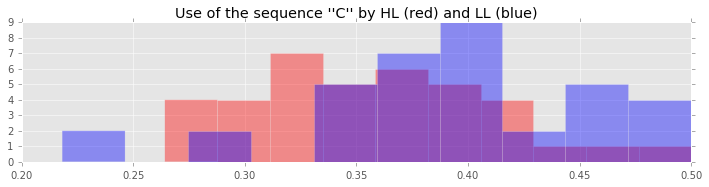

C :
	T-test:	-2.459 	 p=0.0165
	HL<LL:	427.0 	 p=0.0028
	HL>LL:	427.0 	 p=0.9973


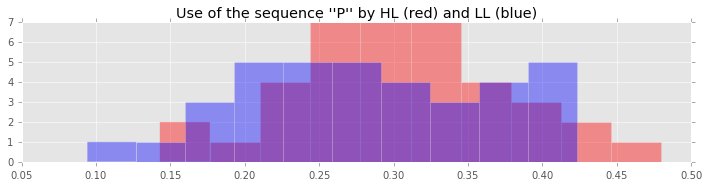

P :
	T-test:	1.141 	 p=0.2577
	HL<LL:	784.5 	 p=0.8627
	HL>LL:	784.5 	 p=0.1397


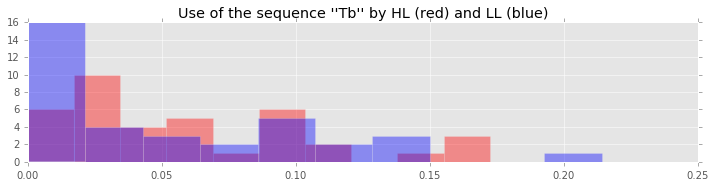

Tb :
	T-test:	0.69 	 p=0.4922
	HL<LL:	799.5 	 p=0.8971
	HL>LL:	799.5 	 p=0.1048


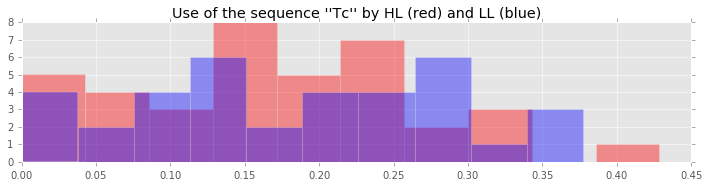

Tc :
	T-test:	-0.568 	 p=0.572
	HL<LL:	630.5 	 p=0.2832
	HL>LL:	630.5 	 p=0.7204


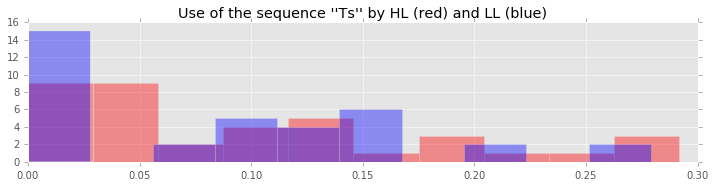

Ts :
	T-test:	0.68 	 p=0.499
	HL<LL:	763.5 	 p=0.8083
	HL>LL:	763.5 	 p=0.1947


In [85]:
for action in actions_all:
    freq_HL,freq_LL = get_frequencies(action,blocks_HL,blocks_LL,normalize_by='length')
    plot = make_hist_continuous(action,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(action,freq_HL,freq_LL)

** <font color='blue'> Clearly, LL have more construction blocks per number of action blocks ($p < 0.05$) </font> **

# Let's start digging into our Hypotheses
## Hypothesis 1.2 and 3.2: What to do after testing? 
### HL do more TsP?
Let's see if they Test simple then pause more, given the length of their sequences (normalizing by it)
and then given the number of times they Test simple (normalizing by the number of times they Test simple)

TsP :
	T-test:	1.521 	 p=0.1326
	HL<LL:	835.0 	 p=0.9527
	HL>LL:	835.0 	 p=0.0484


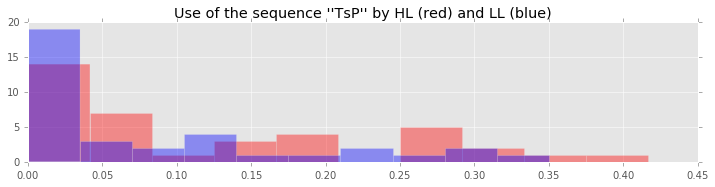

In [86]:
seq = 'TsP'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

TsP :
	T-test:	2.649 	 p=0.0099
	HL<LL:	911.5 	 p=0.9941
	HL>LL:	911.5 	 p=0.0061


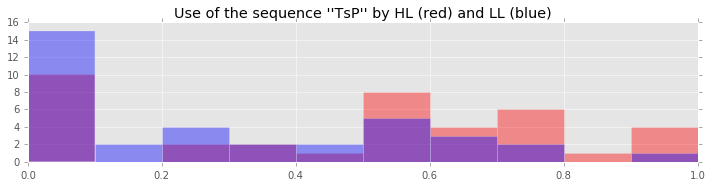

In [87]:
seq = 'TsP'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='Ts')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

** <font color='blue'> Not only do they TsP more overall ($p < 0.05$) </font> **

** <font color='blue'> They also Pause more after Testing simple. ($p < 0.01$) </font> **

Do LL Construct after Testing simple then?

In [90]:
# for seq in ['TsC','TsTc','TsTb']:
#     freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='Ts')
#     make_hist_continuous(seq,freq_HL,freq_LL)
#     perform_comparative_stats(seq,freq_HL,freq_LL)

### LL do more TcC?

TcC :
	T-test:	-1.612 	 p=0.1114
	HL<LL:	539.5 	 p=0.0594
	HL>LL:	539.5 	 p=0.9419


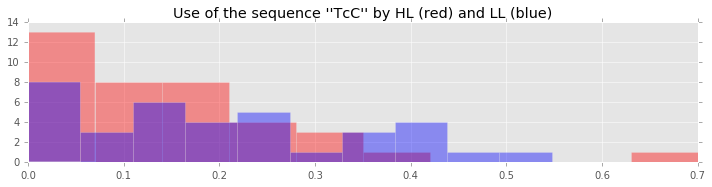

In [91]:
seq = 'TcC'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

TcC :
	T-test:	-2.075 	 p=0.0416
	HL<LL:	486.5 	 p=0.0163
	HL>LL:	486.5 	 p=0.9841


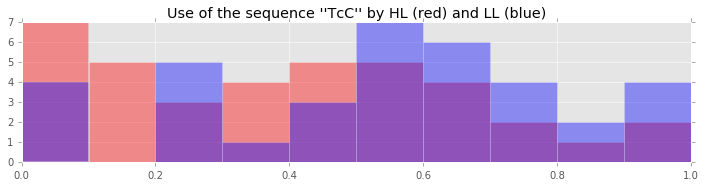

In [92]:
seq = 'TcC'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='Tc')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

** <font color='blue'> LL don't necessarily Test complex + Construct more often but they do Construct after Testing Complex more ($p < 0.05$) </font> **

### Let's generalize these hypotheses and repeat the analysis for TP and TC
We merge all test actions (and don't ignore Test Other for this analysis)

TP :
	T-test:	2.396 	 p=0.0194
	HL<LL:	927.5 	 p=0.9958
	HL>LL:	927.5 	 p=0.0043


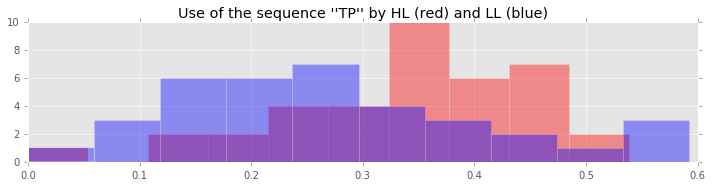

In [93]:
seq = 'TP'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

TP :
	T-test:	2.21 	 p=0.0304
	HL<LL:	885.5 	 p=0.9856
	HL>LL:	885.5 	 p=0.0148


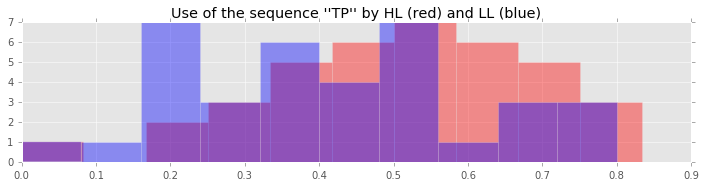

In [94]:
seq = 'TP'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='T')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

TC :
	T-test:	-1.708 	 p=0.092
	HL<LL:	540.0 	 p=0.0603
	HL>LL:	540.0 	 p=0.941


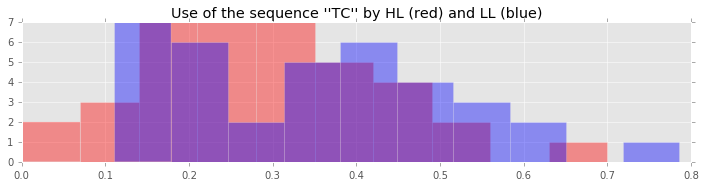

In [96]:
seq = 'TC'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

TC :
	T-test:	-2.889 	 p=0.0051
	HL<LL:	433.5 	 p=0.0034
	HL>LL:	433.5 	 p=0.9967


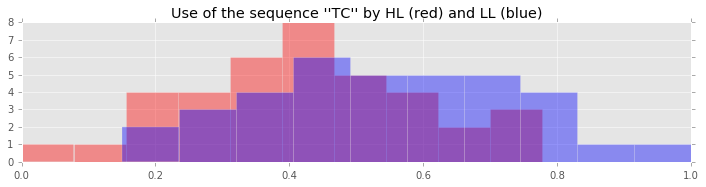

In [97]:
seq = 'TC'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='T')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)

** <font color='blue'> HL Test and Pause more overall ($p < 0.05$) as well as Pause more after Testing ($p < 0.05$)</font> **

** <font color='blue'> LL don't necessarily Test and Constrcut more overall but they do Construct after Testing more ($p < 0.01$) </font> **

## Hypothesis 5.1 and 5.2: LL do more CP or PC?

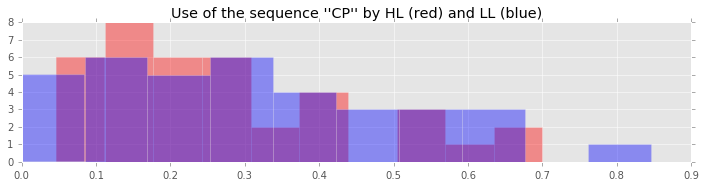

CP :
	T-test:	-0.682 	 p=0.4978
	HL<LL:	640.0 	 p=0.319
	HL>LL:	640.0 	 p=0.6848


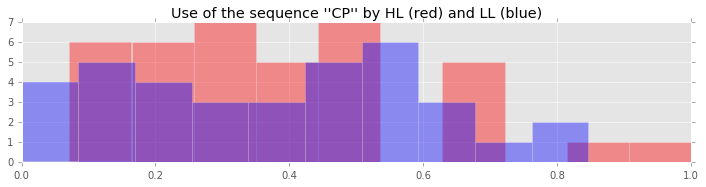

CP :
	T-test:	0.019 	 p=0.9847
	HL<LL:	677.0 	 p=0.472
	HL>LL:	677.0 	 p=0.5323


In [100]:
seq = 'CP'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='C')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)

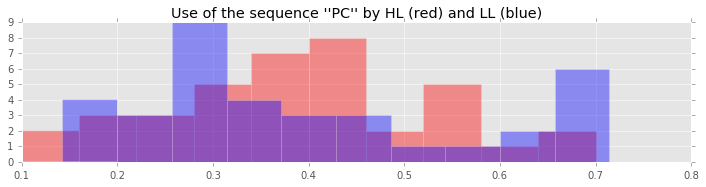

PC :
	T-test:	-0.265 	 p=0.7917
	HL<LL:	707.0 	 p=0.6003
	HL>LL:	707.0 	 p=0.4039


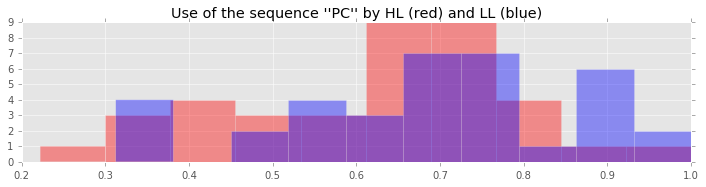

PC :
	T-test:	-1.445 	 p=0.153
	HL<LL:	560.0 	 p=0.0906
	HL>LL:	560.0 	 p=0.9111


In [101]:
seq = 'PC'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)

So no trends whatsoever... but clearly pauses are important after testing, so let's investigate.
## So everyone pauses during the activity, but they possibly use pauses differently...

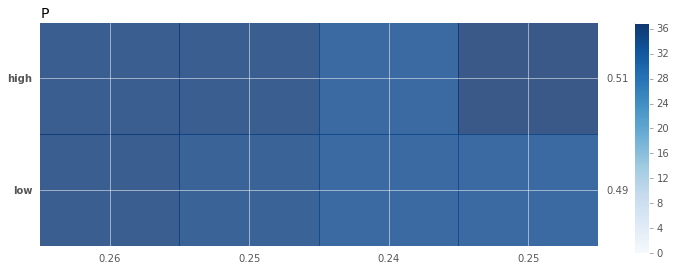

In [102]:
plot = plot_heat_map(sequence_counts['P'],'P',('high','low'))

Let's look at the following sequences:
* TPC may suggest a form of reflection with potentially some planning of a construction (results of test are recorded and/or driving the next construction)
* TPT is most probably reflection between tests or prediction of next test
* CPT is prediction OR reflecting on implicit feedback from construction
* CPC demonstrates planning of a construction or implicit feedback from construction

### First let's compare the groups and sequences normalizing by the number of pausses.

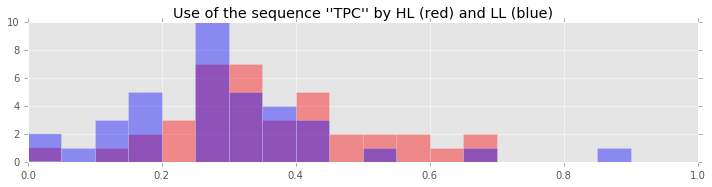

TPC :
	T-test:	1.671 	 p=0.0992
	HL<LL:	862.0 	 p=0.9734
	HL>LL:	862.0 	 p=0.0272


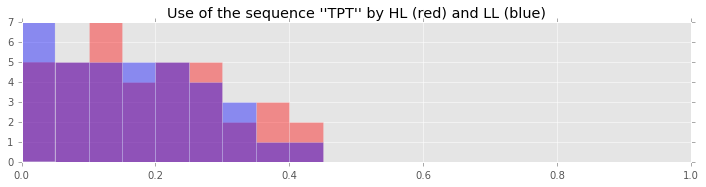

TPT :
	T-test:	0.731 	 p=0.467
	HL<LL:	747.0 	 p=0.7545
	HL>LL:	747.0 	 p=0.2489


In [121]:
for seq in ['TPC','TPT']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)

HL and LL are not very different here in their use of these sequences, however overall, students TPC more then they TPT
This may suggest that iterative testing on the same circuit or the comparison of circuits is not a frequent strategy. Students only perform a single block of Test + Pause before constructing again

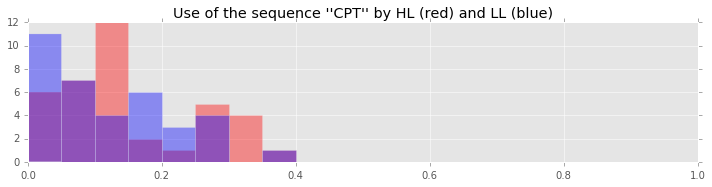

CPT :
	T-test:	1.311 	 p=0.194
	HL<LL:	790.5 	 p=0.878
	HL>LL:	790.5 	 p=0.1243


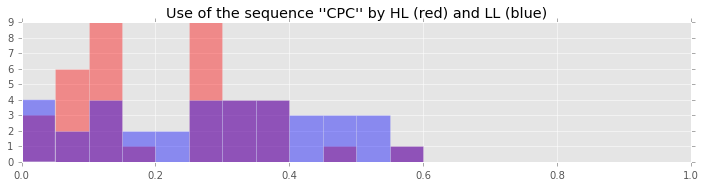

CPC :
	T-test:	-1.971 	 p=0.0528
	HL<LL:	503.0 	 p=0.0253
	HL>LL:	503.0 	 p=0.9753


In [122]:
for seq in ['CPT','CPC']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)

** <font color='blue'> LL don't necessarily CPT given how much they pause but they do CPC more ($p < 0.05$) </font> **

In other words, LL spend a lot of time planning their construction of their circuits OR use their construction to get implicit feedback. But again this goes back to Testing as the feedback you get impplicitly is immediate and requires attention at the right time. Moreover not all implicit feedback may be noticed by the student.

### Now let's do a very similar analysis normalizing this time by the first two action of the sequence

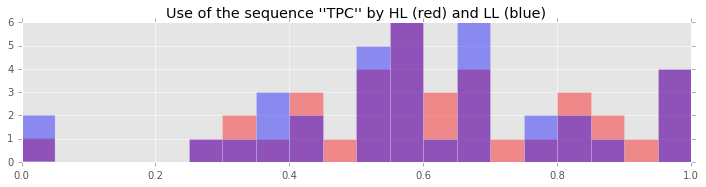

TPC :
	T-test:	0.558 	 p=0.5784
	HL<LL:	727.0 	 p=0.6814
	HL>LL:	727.0 	 p=0.3225


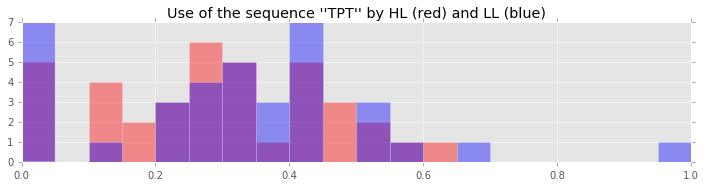

TPT :
	T-test:	-0.632 	 p=0.5293
	HL<LL:	629.5 	 p=0.2788
	HL>LL:	629.5 	 p=0.7249


In [123]:
for seq in ['TPC','TPT']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='TP')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)

We find a very similar pattern: students TPC more than they iteratively test (TPT)

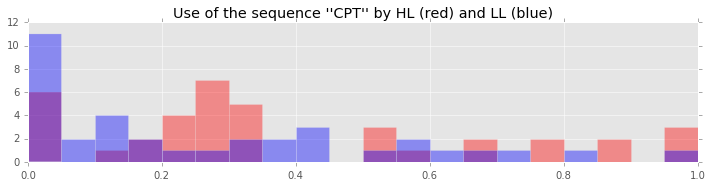

CPT :
	T-test:	1.663 	 p=0.1006
	HL<LL:	840.5 	 p=0.9563
	HL>LL:	840.5 	 p=0.0447


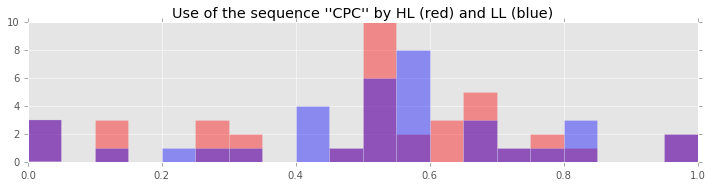

CPC :
	T-test:	-0.428 	 p=0.67
	HL<LL:	655.5 	 p=0.3804
	HL>LL:	655.5 	 p=0.6238


In [124]:
for seq in ['CPT','CPC']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='CP')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)

Given a construction and pause block, students tend to construct rather then Test.

However, ** <font color='blue'> almost a third of LL  (10 students) never T after a CP block and in general they do it less then HL ($p < 0.05$) </font> **

Thus, if Testing after a Construct and Pause block is a sign of prediction, LL use pauses as predctions less than HL.

## What about repetitions of building blocks?